**DICOM to NifTI converter** - didn't work well (had to rerun on Linux computer)

This scrips uses dcm2niix (https://github.com/rordenlab/dcm2niix/releases) converter

In [1]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import nibabel
import numpy as np

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans

%matplotlib qt

import pandas as pd
import numpy as np
import os
from utils import check_paths


__________________

EXTRACT FILES FROM ARCHIVES

In [28]:
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
print(fs_dir)

D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir


In [ ]:
import os
import tarfile

#! sub07 was faulty (had many subfolders in the archive), beeded manual extraction
# DONE!

# Base directory containing subject folders or archives
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
groups = ["Y", "O"]

for group in groups:
    base_dir = os.path.join(fs_dir, group)

    # List all items in the directory
    for file_name in os.listdir(base_dir):

        # Construct the full file path
        file_path = os.path.join(base_dir, file_name)

        # Check for tar or zip archive
        if file_name.endswith('.tar') or file_name.endswith('.tar.gz'):
            sub_name = os.path.splitext(os.path.splitext(file_name)[0])[0]  # removes .tar/.gz
            # extract_dir = os.path.join(base_dir, sub_name)
            
            os.makedirs(base_dir, exist_ok=True)
            print(f'Extracting {file_name} to {base_dir}...')

            with tarfile.open(file_path, 'r') as tar:
                tar.extractall(path=base_dir)

print('All archives processed.')


_____________________________

**Sanity check: visualisation of FS files**

In [67]:
# subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
subject = "s1_pac_sub01"
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: D:/BonoKat/research project/# study 1/mri_data/fs_output/freesurfer/sub_dir/Y/s1_pac_sub01/mri/T1.mgz (256, 256, 256)>

Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [ ]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

__________________________________

CHECK BEM SURFACES

In [31]:
bem_path = os.path.join(subjects_dir, subject, 'bem', f"{subject}-head.fif")
surfaces = mne.read_bem_surfaces(bem_path)

    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


In [70]:
import mne
from mne.datasets import fetch_fsaverage

# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 134495, Faces: 268986


In [32]:
# Test a cortical surface
coords, faces = mne.read_surface(f"{subjects_dir}/{subject}/surf/lh.pial")
print(f"✅ lh.pial loaded: {len(coords)} vertices, {len(faces)} faces")

✅ lh.pial loaded: 134495 vertices, 268986 faces


___

GROUP ANALYSIS

In [ ]:
# SET EEG MONTAGE FROM DIGITIZER FILES
# DONE

eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'

groups = ['Y', 'O']
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go']
block_names = ['_baseline', '_adaptation']

for group in groups:
    dig_folder = f'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\{group}'
    dig_group_dir = os.path.join(eeg_data_dir, group)
    subjects_dir = os.path.join(eeg_data_dir, group)

    for subject in os.listdir(subjects_dir):
        eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
        analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
        source_path = os.path.join(analysis_path, 'source')
        check_paths(source_path)

        ######## ADJUST DIGITIZER FILES AND CREATE MONTAGE ########
        dig_file = os.path.join(dig_folder, f"{subject}.txt")
        # Set the header line
        column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
        cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

        # Load the data, skipping the header lines
        dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
        dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
        dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
        dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
        dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

        # Convert mm to m
        dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

        # EEG electrodes
        eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
        eeg_pos = dict(zip(
            eeg_df['Electrode Name'],
            np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
        ))

        # Fiducials
        fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
        fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
                for _, row in fid_df.iterrows()}

        # Lowercase the montage keys to match MNE style
        montage_renamed = {
            k.strip().capitalize(): v for k, v in eeg_pos.items()
        }
        # Create montage
        montage = mne.channels.make_dig_montage(
            ch_pos=eeg_pos,
            # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
            # lpa=fid_pos['lpa'],
            # rpa=fid_pos['rpa'],
            coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
        )

        ######## READ ALL EPOCHS FILES AND SET MONTAGE ########
        # Loop through all task stages and blocks
        for task in tasks:
            for task_stage in task_stages:
                if task == '_BL':
                    epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)
                    epochs.set_montage(montage, match_case=False)
                    epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'), overwrite=True)
                else:
                    for block_name in block_names:
                        epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                        epochs = mne.read_epochs(epochs_file)
                        epochs.set_montage(montage, match_case=False)
                        epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-epo_montage.fif'), overwrite=True)


In [6]:
print(info)

D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\source\s1_pac_sub01__BL_plan-epo_montage.fif


In [ ]:
# MANUAL COREGISTRATION: 1 recording per subject

group = 'Y'
task = '_BL'
task_stage = '_plan'
fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
subjects_dir = os.path.join(eeg_data_dir, group)
subject = os.listdir(subjects_dir)[1] # change index to select a subject
print(f'Selecting subject: {subject}')

eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')

info = os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif')
mne.gui.coregistration(subject=subject,
                    subjects_dir=fs_subjects_dir,
                    inst=info,
                    )


Selecting subject: s1_pac_sub07
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub07\bem\s1_pac_sub07-head-dense.fif
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif... Done!
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub07\bem\s1_pac_sub07-head-dense.fif
    Triangle neighbors and vertex normals...
Estimating fiduc

Placing MRI fiducials - NASION
Placing MRI fiducials - RPA
Saving D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub07\bem\s1_pac_sub07-fiducials.fif...
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub07\bem\s1_pac_sub07-fiducials.fif... Done!
Saving D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub07\bem\s1_pac_sub07-fiducials.fif... Done!
Using s1_pac_sub07-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	eeg: 60
Aligning using fiducials
Start median distance:  11.34 mm
End   median distance:  17.28 mm
Fitting fiducials finished in 0.07 seconds.
Channel types::	eeg: 60
Aligning using ICP
Start     median distance:  17.28 mm
  ICP  1  median distance:  13.70 mm
Fitting ICP - iteration 1
Channel types::	eeg: 60
  ICP  2  median distance:  12.59 mm
Fitting ICP - ite

In [12]:
# CHECK COREGISTRATION
epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))

trans_file = os.path.join(source_path, f'{subject}-trans.fif')
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info=epochs.info,
    trans=trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=fs_subjects_dir,
    surfaces=["head-dense"],
)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub07\preproc\analysis\source\s1_pac_sub07_BL_plan-epo_montage.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
102 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using s1_pac_sub07-head-dense.fif for head surface.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_38168\621008975.py:2: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub07\preproc\analysis\source\s1_pac_sub07_BL_plan-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))


    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	eeg: 60


In [ ]:
# SOURCE SPACE
task = '_BL'
task_stage = '_plan' # any task / stage can be used, since the source space is the same for all tasks

conductivity = (0.3, 0.006, 0.3)  # for three layers

for group in groups:
    fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    subjects_list = [folder.name for folder in os.scandir(fs_subjects_dir) if folder.is_dir()]

    for subject in subjects_list:
        print(f"Setting up source space for subject: {subject}")
        source_path = os.path.join(eeg_data_dir, group, subject, 'preproc', 'analysis', 'source')

        # Set up the source space
        src = mne.setup_source_space(
            subject, spacing="ico5", add_dist="patch", subjects_dir=fs_subjects_dir # ico5 - high, but not maximal resolution (2,562 vertices per hemisphere)
        )

        # BEM model
        model = mne.make_bem_model(
            subject=subject, ico=4, conductivity=conductivity, subjects_dir=fs_subjects_dir
        )
        bem = mne.make_bem_solution(model)

        # Forward solution
        epochs = mne.read_epochs(os.path.join(source_path, f'{subject}_{task}{task_stage}-epo_montage.fif'))
        trans_file = os.path.join(source_path, f'{subject}-trans.fif')
        trans = mne.read_trans(trans_file)
        
        fwd = mne.make_forward_solution(
            info=epochs.info,
            trans=trans,
            src=src,
            bem=bem,
            eeg=True,
            n_jobs=-1,
        )
        print(fwd)

        # Save source space, BEM model, and forward solution
        # Save the source space
        src_fname = os.path.join(source_path, f"{subject}-ico5-src.fif")
        mne.write_source_spaces(src_fname, src)

        # Save BEM model
        bem_model_fname = os.path.join(source_path, f"{subject}-bem-model.fif")
        mne.write_bem_surfaces(bem_model_fname, model)

        # Save BEM solution
        bem_sol_fname = os.path.join(source_path, f"{subject}-bem-sol.fif")
        mne.write_bem_solution(bem_sol_fname, bem)

        # Save forward solution
        fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
        mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

        print(f"Saved all source modeling files to: {source_path}")

STOPPED HERE
1. Find optimal source reconstruction method
2. Inverse operator - on evoked (higher snr); sources - on epochs (for PAC)


In [ ]:
# For each recording ! 
# Noise covariance matrix
noise_cov = mne.compute_covariance(epochs, tmax=0, method='empirical', rank=None) # method='empirical' for optimal regularisation
noise_cov.plot(epochs.info)

evoked = epochs.average()

# Compute the inverse operator
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2)

# Compute the source estimates: on evoked data (!)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1. / 9.)
stc.plot()

_____________________

SINGLE SUB ANALYSIS

Reading electrode locations

In [ ]:
dig_folder = 'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\Y'
subject = 's1_pac_sub01'
dig_file = os.path.join(dig_folder, f"{subject}.txt")

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

In [34]:
# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))

# Fiducials
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
           for _, row in fid_df.iterrows()}

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
    # lpa=fid_pos['lpa'],
    # rpa=fid_pos['rpa'],
    coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
)


In [42]:
## SANITY CHECK
# Plot channels and fiducials

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, row in dig_points_df.iterrows():
    x, y, z = row["Loc. X"], row["Loc. Y"], row["Loc. Z"]
    label = row["Electrode Name"]
    ax.scatter(x, y, z, marker='o')
    ax.text(x, y, z, label, color='red')  # label each point

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Electrode positions')

plt.show()


In [ ]:
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo.fif'
epochs = mne.read_epochs(epochs_file)
epochs.set_montage(montage, match_case=False)
epochs.info['dig']
epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)

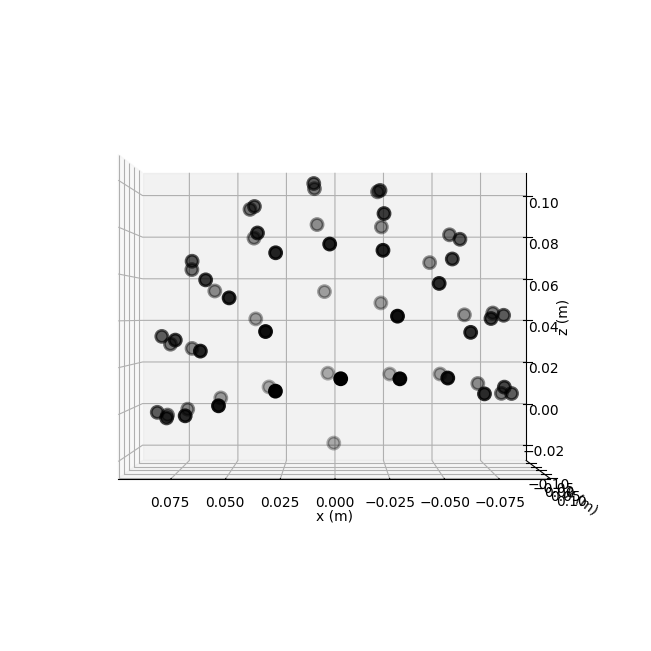

In [164]:
epochs.plot_sensors(kind='3d')

In [ ]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
info = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif'
mne.gui.coregistration(subject=subject,
                       subjects_dir=subjects_dir,
                       inst=info,
                       )


PLOT BEM SURFACES - optional

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


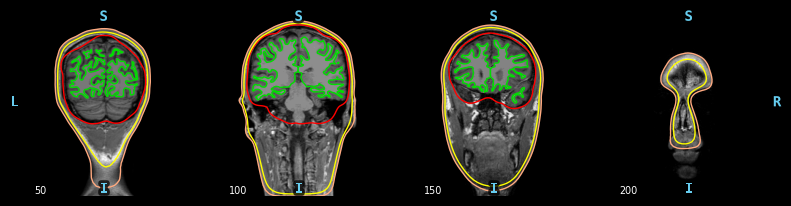

In [64]:
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=fs_subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

CHECK COREGISTRATION

In [ ]:
info = epochs.info
trans_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\{subject}-trans.fif'
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info,
    trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=subjects_dir,
    surfaces=["head-dense"],
)

COMPUTE SOURCE SPACE

In [ ]:
# Set up the source space
src = mne.setup_source_space(
    subject, spacing="ico4", add_dist="patch", subjects_dir=subjects_dir
)
print(src)

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


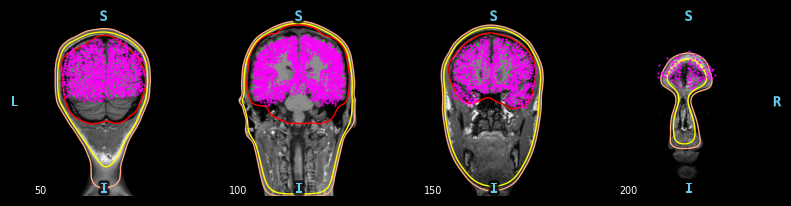

In [187]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

In [225]:
fig = mne.viz.plot_alignment(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="white",
    coord_frame="mri",
    src=src,
)
mne.viz.set_3d_view(
    fig,
    azimuth=173.78,
    elevation=101.75,
    distance=0.30,
    focalpoint=(-0.03, -0.01, 0.03),
)

In [ ]:
# BEM model
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(
    subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir
)
bem = mne.make_bem_solution(model)

In [ ]:
# Forward solution
fwd = mne.make_forward_solution(
    info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    n_jobs=-1,
    # verbose=True,
)
print(fwd)

In [202]:
print(f"Before: {src}")
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] MRI (surface RAS) coords, subject 's1_pac_sub01', ~25.3 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] head coords, subject 's1_pac_sub01', ~25.3 MB>


___

! FOR EACH EPOCHS FILE

In [ ]:
# For each recording ! 
# Noise covariance matrix
noise_cov = mne.compute_covariance(epochs, tmax=0, method='empirical', rank=None) # method='empirical' for optimal regularisation
noise_cov.plot(epochs.info)

evoked = epochs.average()
evoked.plot_white(noise_cov, time_unit="s")

# Compute the inverse operator
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2)

# Compute the source estimates: on evoked data (!)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1. / 9.)
stc.plot()
